# 读取数据

In [203]:
import csv
import re
import pandas as pd
import matplotlib.pylab as plt
import string                            #导入字符串模块
import nltk

from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk.corpus import wordnet

from unicodedata import normalize
import numpy as np

import numpy as np
import matplotlib.pyplot as plt


In [204]:
csvFile = open('word_n_standard.csv', 'r')
reader = csv.reader(csvFile)
standard_word = [] # 需要考虑的词集
noun_n = 50
source = [] # 存放产品分级的词频数组
source_p = [] # 存放产品的词频数组


In [205]:
for item in reader:
    # 忽略第一行
    if reader.line_num == 1:
        continue
    if reader.line_num > noun_n:
        break
    standard_word.append(item[0])

In [206]:
tab1 = "./hair_dryer.tsv"
tab2 = "."
df_hd = pd.read_csv(tab1, sep='\t', header=0)
df_hd.head()
df_hd = df_hd[~(df_hd['vine'].str.contains("N") & df_hd['verified_purchase'].str.contains("N"))]
df_hd = df_hd[(df_hd['total_votes'] > 0) & (df_hd['helpful_votes'] > 0)]

df_hd = df_hd.groupby('product_parent').filter(lambda x: len(x) > 10)

In [207]:
#import nltk resources
resources = ["wordnet", "stopwords", "punkt", \
             "averaged_perceptron_tagger", "maxent_treebank_pos_tagger"]

for resource in resources:
    try:
        nltk.data.find("tokenizers/" + resource)
    except LookupError:
        nltk.download(resource)

#create Lemmatizer object
lemma = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /home/alphonse/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alphonse/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/alphonse/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_treebank_pos_tagger to
[nltk_data]     /home/alphonse/nltk_data...
[nltk_data]   Package maxent_treebank_pos_tagger is already up-to-
[nltk_data]       date!


In [208]:
def lemmatize_word(tagged_token):
    """ Returns lemmatized word given its tag"""
    root = []
    for token in tagged_token:
        tag = token[1][0]
        word = token[0]
        if tag.startswith('J'):
            root.append(lemma.lemmatize(word, wordnet.ADJ))
        elif tag.startswith('V'):
            root.append(lemma.lemmatize(word, wordnet.VERB))
        elif tag.startswith('N'):
            root.append(lemma.lemmatize(word, wordnet.NOUN))
        elif tag.startswith('R'):
            root.append(lemma.lemmatize(word, wordnet.ADV))
        else:          
            root.append(word)
    return root


In [209]:
def lemmatize_doc(document):
    """ Tags words then returns sentence with lemmatized words"""
    lemmatized_list = []
    tokenized_sent = sent_tokenize(document)
    for sentence in tokenized_sent:
        no_punctuation = re.sub(r"[`'\",.!?()]", " ", sentence)
        tokenized_word = word_tokenize(no_punctuation)
        tagged_token = pos_tag(tokenized_word)
        lemmatized = lemmatize_word(tagged_token)
        lemmatized_list.extend(lemmatized)
    return " ".join(lemmatized_list)

In [210]:
# 定义处理函数
def process_data(df_pp):
    pattern = r"\&\#[0-9]+\;"
    df_pp["preprocessed"] = df_pp["review_body"].str.replace(pat=pattern, repl="", regex=True)
    
    df_pp["preprocessed"] = df_pp["preprocessed"].apply(lambda row: lemmatize_doc(row))
    
    remove_accent = lambda text: normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8", "ignore")
    df_pp["preprocessed"] = df_pp["preprocessed"].apply(remove_accent)
    
    pattern = r"[^\w\s]"
    df_pp["preprocessed"] = df_pp["preprocessed"].str.replace(pat=pattern, repl=" ", regex=True)

    df_pp["preprocessed"] = df_pp["preprocessed"].str.lower()

    pattern = r"[\s]+"

    df_pp["preprocessed"] = df_pp["preprocessed"].str.replace(pat=pattern, repl=" ", regex=True)
    
    corpora = df_pp["preprocessed"].values
    tokenized = [corpus.split(" ") for corpus in corpora]

    return tokenized

In [211]:
# 遍历分组
for key, group in df_hd.groupby('product_parent'):
    product_r = list()
    # 遍历星级
    for star in range(1, 6):
        star_r = [0] * noun_n
        # df_pp 代表当前产品某一星级的数据
        df_pp = group[group['star_rating'] == star]
        tokenized = process_data(df_pp)
        for review in tokenized:
            for word in review:
                if word in standard_word:
                    star_r[standard_word.index(word)] = star_r[standard_word.index(word)] + 1
        product_r.append(star_r)

    source.append(product_r)

/home/alphonse/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/alphonse/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/alphonse/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



In [212]:
source_p = []
for product_r in source:
    array = np.array(product_r[0])+ np.array(product_r[1]) + np.array(product_r[2]) + np.array(product_r[3]) + np.array(product_r[4])
    source_p.append(array.tolist())
source_p

[[2,
  3,
  18,
  0,
  2,
  2,
  0,
  0,
  0,
  0,
  0,
  2,
  2,
  0,
  1,
  2,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  2,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  3,
  0,
  1,
  3,
  2,
  0,
  0,
  1,
  2,
  0],
 [3,
  4,
  13,
  1,
  7,
  3,
  3,
  3,
  0,
  1,
  6,
  6,
  3,
  1,
  0,
  1,
  1,
  1,
  0,
  0,
  3,
  1,
  0,
  0,
  1,
  0,
  5,
  2,
  1,
  0,
  0,
  0,
  0,
  0,
  4,
  0,
  1,
  0,
  2,
  2,
  5,
  0,
  0,
  0,
  0,
  2,
  3,
  2,
  1,
  0],
 [42,
  31,
  24,
  112,
  15,
  22,
  21,
  20,
  8,
  42,
  4,
  21,
  7,
  18,
  5,
  17,
  8,
  5,
  3,
  4,
  6,
  8,
  2,
  12,
  12,
  3,
  7,
  11,
  16,
  1,
  0,
  2,
  6,
  9,
  16,
  35,
  5,
  1,
  4,
  1,
  7,
  1,
  6,
  3,
  2,
  4,
  32,
  4,
  13,
  0],
 [9,
  1,
  0,
  8,
  4,
  1,
  0,
  2,
  3,
  1,
  2,
  3,
  1,
  0,
  0,
  4,
  0,
  1,
  4,
  0,
  0,
  11,
  14,
  5,
  3,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  2,
  4,
  1,
  1,
  18,
  10,
  2,
  1,
  0,
  1,
  0,


In [213]:
print(source_p)

[[2, 3, 18, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 1, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0, 1, 0, 0, 1, 3, 0, 1, 3, 2, 0, 0, 1, 2, 0], [3, 4, 13, 1, 7, 3, 3, 3, 0, 1, 6, 6, 3, 1, 0, 1, 1, 1, 0, 0, 3, 1, 0, 0, 1, 0, 5, 2, 1, 0, 0, 0, 0, 0, 4, 0, 1, 0, 2, 2, 5, 0, 0, 0, 0, 2, 3, 2, 1, 0], [42, 31, 24, 112, 15, 22, 21, 20, 8, 42, 4, 21, 7, 18, 5, 17, 8, 5, 3, 4, 6, 8, 2, 12, 12, 3, 7, 11, 16, 1, 0, 2, 6, 9, 16, 35, 5, 1, 4, 1, 7, 1, 6, 3, 2, 4, 32, 4, 13, 0], [9, 1, 0, 8, 4, 1, 0, 2, 3, 1, 2, 3, 1, 0, 0, 4, 0, 1, 4, 0, 0, 11, 14, 5, 3, 1, 1, 0, 1, 0, 1, 1, 0, 2, 4, 1, 1, 18, 10, 2, 1, 0, 1, 0, 1, 1, 0, 0, 3, 0], [4, 3, 0, 0, 1, 3, 1, 4, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 5, 0, 1, 1, 0, 1, 2, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0], [23, 7, 12, 4, 2, 0, 8, 5, 6, 18, 6, 3, 6, 4, 4, 5, 5, 0, 1, 2, 1, 4, 4, 2, 3, 2, 2, 2, 7, 0, 0, 0, 2, 2, 4, 7, 1, 0, 3, 9, 2, 1, 0, 2, 1, 1, 7, 1, 3, 0], [5, 1, 2, 2, 5, 1, 0, 1, 0, 0, 1, 1, 0, 0, 7, 4, 4, 2, 0,

# PCA

In [214]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets.samples_generator import make_blobs

In [216]:
#先不降维，只对数据进行投影，看看投影后的三个维度的方差分布
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
pca.fit(source_p)
#返回所保留的n个成分各自的方差百分比
print(pca.explained_variance_ratio_)
print(pca.explained_variance_)



[4.79535767e-01 1.66026988e-01 7.29231037e-02 5.78118273e-02
 3.37271683e-02 2.52984550e-02 1.99203207e-02 1.89421612e-02
 1.50351169e-02 1.26343029e-02 1.06053568e-02 9.25994051e-03
 8.47945318e-03 7.69861351e-03 6.56949472e-03 5.85198529e-03
 4.57129466e-03 4.46122065e-03 3.87382090e-03 3.48496811e-03
 3.11020669e-03 3.04087587e-03 2.88249331e-03 2.50167847e-03
 2.30819943e-03 2.12107894e-03 1.79542894e-03 1.60796767e-03
 1.51075725e-03 1.41698255e-03 1.33692881e-03 1.18264069e-03
 1.13629006e-03 8.99944876e-04 8.57343100e-04 7.86410795e-04
 7.24119694e-04 6.34554723e-04 5.60876377e-04 5.44299597e-04
 4.31917311e-04 3.86538237e-04 3.47258223e-04 3.16251982e-04
 2.45814232e-04 2.04682402e-04 1.68182380e-04 1.42065644e-04
 8.68524801e-05 3.31698358e-33]
[5.15025128e+02 1.78314271e+02 7.83199782e+01 6.20903503e+01
 3.62232400e+01 2.71707366e+01 2.13945787e+01 2.03440279e+01
 1.61478320e+01 1.35693392e+01 1.13902354e+01 9.94524783e+00
 9.10699839e+00 8.26837053e+00 7.05568821e+00 6.28507

In [ ]:
#进行降维，从三维降到20维
pca1 = PCA(n_components=50)
pca1.fit(X)
#返回所保留的n个成分各自的方差百分比
print(pca1.explained_variance_ratio_)
print(pca1.explained_variance_)
print(pca1.n_components_)

/home/alphonse/anaconda3/envs/pytorch/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


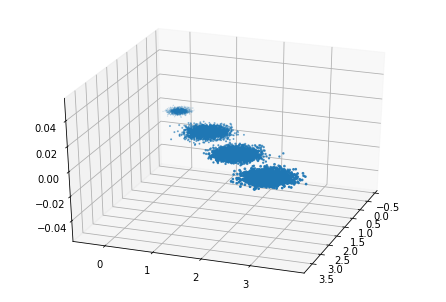

In [185]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from sklearn.datasets.samples_generator import make_blobs
# X为样本特征，Y为样本簇类别， 共1000个样本，每个样本3个特征，共4个簇
X, y = make_blobs(n_samples=10000, n_features=3, centers=[[3,3, 3], [0,0,0], [1,1,1], [2,2,2]], cluster_std=[0.2, 0.1, 0.2, 0.2], 
                  random_state =9)
fig = plt.figure()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=30, azim=20)
plt.scatter(X[:, 0], X[:, 1], X[:, 2],marker='o')

In [196]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
pca.fit(X)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_)

ValueError: n_components=4 must be between 0 and min(n_samples, n_features)=3 with svd_solver='full'